In [303]:
# libraries import
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
from keras._tf_keras.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeRegressor
from sklearn import svm
from sklearn.model_selection import RandomizedSearchCV

In [304]:
df = pd.read_excel('fig3.xlsx')
print(df)

       cycles crack length       cycles.1 crack length.1       cycles.2  \
0         NaN           mm            NaN             mm            NaN   
1    R=0.1,CA     R=0.1,CA  R=0.1,OLR=1.5  R=0.1,OLR=1.5  R=0.1,OLR=2.0   
2        9210      10.2752           9984        10.3196           7528   
3       11186      10.3271          12236         10.371           9281   
4       13372      10.3835          17057         10.423          11247   
..        ...          ...            ...            ...            ...   
245    137559      23.1331         190757         23.223            NaN   
246    137629      23.1878         190838        23.2772            NaN   
247    137691      23.2419         190894        23.3292            NaN   
248    137747      23.2949         190971        23.3804            NaN   
249    137810      23.3462         191033        23.4311            NaN   

    crack length.2  cycles.3 crack length.3       cycles.4 crack length.4  \
0               mm    

In [305]:
# Split the data into experiments
E1 = df.iloc[:, 0:2]
E1 = E1.iloc[2:, :]
E1.columns = ['cycles', 'crack length']
E1['R'], E1['OLR'] = 0.1, None

E2 = df.iloc[:, 2:4]
E2 = E2.iloc[2:, :]
E2.columns = ['cycles', 'crack length']
E2['R'], E2['OLR'] = 0.1, 1.5

E3 = df.iloc[:, 4:6]
E3 = E3.iloc[2:, :]
E3.columns = ['cycles', 'crack length']
E3['R'], E3['OLR'] = 0.1, 2.0

E4 = df.iloc[:, 6:8]
E4 = E4.iloc[2:, :]
E4.columns = ['cycles', 'crack length']
E4['R'], E4['OLR'] = 0.3, None

E5 = df.iloc[:, 8:10]
E5 = E5.iloc[2:, :]
E5.columns = ['cycles', 'crack length']
E5['R'], E5['OLR'] = 0.3, 1.5

E6 = df.iloc[:, 10:12]
E6 = E6.iloc[2:, :]
E6.columns = ['cycles', 'crack length']
E6['R'], E6['OLR'] = 0.3, 2.0

E7 = df.iloc[:, 12:14]
E7 = E7.iloc[2:, :]
E7.columns = ['cycles', 'crack length']
E7['R'], E7['OLR'] = 0.5, None

E8 = df.iloc[:, 14:16]
E8 = E8.iloc[2:, :]
E8.columns = ['cycles', 'crack length']
E8['R'], E8['OLR'] = 0.5, 1.5

E9 = df.iloc[:, 16:18]
E9 = E9.iloc[2:, :]
E9.columns = ['cycles', 'crack length']
E9['R'], E9['OLR'] = 0.5, 2.0

E10 = df.iloc[:, 18:20]
E10 = E10.iloc[2:, :]
E10.columns = ['cycles', 'crack length']
E10['R'], E10['OLR'] = 0.7, None

E11 = df.iloc[:, 20:22]
E11 = E11.iloc[2:, :]
E11.columns = ['cycles', 'crack length']
E11['R'], E11['OLR'] = 0.7, 1.5

E12 = df.iloc[:, 22:24]
E12 = E12.iloc[2:, :]
E12.columns = ['cycles', 'crack length']
E12['R'], E12['OLR'] = 0.7, 2.0

# Concatenate all the experiments into one dataframe
data = pd.concat([E1, E2, E3, E4, E5, E6, E7, E8, E9, E10, E11, E12])

CA_data = pd.concat([E1, E4, E7, E10])
OLR_data = pd.concat([E2, E3, E5, E6, E8, E9, E11, E12])

# Drop the ORL column from the CA_data
CA_data = CA_data.drop(['OLR'], axis=1)

# Replace the NaN values with 0 FOR OLR
data['OLR'] = data['OLR'].fillna(0)


# Remove the rows with NaN values
data = data.dropna()
CA_data = CA_data.dropna()
OLR_data = OLR_data.dropna()


/tmp/ipykernel_19422/1755418307.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([E1, E2, E3, E4, E5, E6, E7, E8, E9, E10, E11, E12])


In [306]:
print(data.shape)

print(data.head())

# Check for missing values
print("Train data missing values:")
print(data.isna().values.any())

# Check for empty values
print("Train data empty values:")
print(data.isnull().values.any())

# Check for duplicate rows
print("Train data duplicate rows:")
print(data.duplicated().values.any())



(2417, 4)
  cycles crack length    R  OLR
2   9210      10.2752  0.1  0.0
3  11186      10.3271  0.1  0.0
4  13372      10.3835  0.1  0.0
5  15492      10.4358  0.1  0.0
6  17102      10.4875  0.1  0.0
Train data missing values:
False
Train data empty values:
False
Train data duplicate rows:
False


In [307]:
# Create two separate test sets
CA_test_data = CA_data[(CA_data['R'] == 0.5)]
OLR_test_data = OLR_data[(OLR_data['R'] == 0.5) & (OLR_data['OLR'] == 1.5)]

CA_train_data = pd.concat([CA_data, CA_test_data]).drop_duplicates(keep=False)
ORL_train_data = pd.concat([OLR_data, OLR_test_data]).drop_duplicates(keep=False)

X_train, X_test, y_train, y_test = train_test_split(CA_data.drop('crack length', axis=1), CA_data['crack length'], test_size=0.3, random_state=42)


# Split the training data sets into features and target
CA_X_train = CA_train_data.drop('crack length', axis=1)
CA_y_train = CA_train_data['crack length']

ORL_X_train = ORL_train_data.drop('crack length', axis=1)
ORL_y_train = ORL_train_data['crack length']

# Split the test data sets into features and target
CA_X_test = CA_test_data.drop('crack length', axis=1)
CA_y_test = CA_test_data['crack length']

ORL_X_test = OLR_test_data.drop('crack length', axis=1)
ORL_y_test = OLR_test_data['crack length']

# Scale the data
scaler = MinMaxScaler(feature_range = (0, 1))

# Scale the CA data
CA_X_train_scaled = scaler.fit_transform(CA_X_train)
CA_X_test_scaled = scaler.transform(CA_X_test)

# Sale the OLR data
ORL_X_train_scaled = scaler.fit_transform(ORL_X_train)
ORL_X_test_scaled = scaler.transform(ORL_X_test)


In [308]:
DATA_0_5 = CA_data[(CA_data['R'] == 0.5)]
DATA_0_1 = CA_data[(CA_data['R'] == 0.1)]
DATA_0_3 = CA_data[(CA_data['R'] == 0.3)]
DATA_0_7 = CA_data[(CA_data['R'] == 0.7)]

data = DATA_0_1
X = data.drop('crack length', axis=1).values
y = data['crack length'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
random_state=42)

In [309]:
# Create evaluation function
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy


## RandomForestRegressor

MSE: 0.0013989550480600693


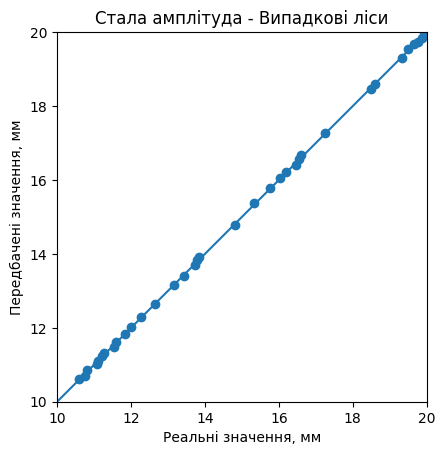

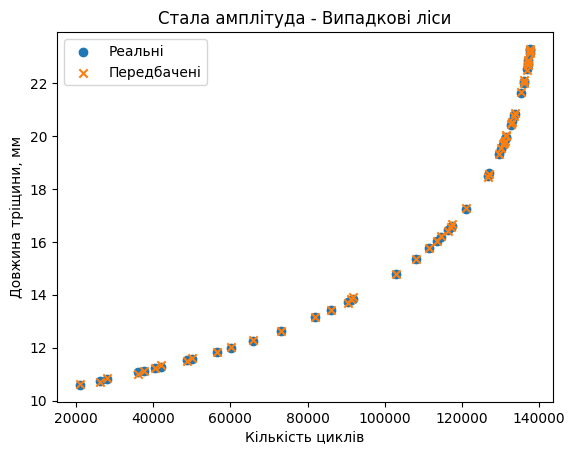

In [310]:
# Predict crack length vs. the number of cycles for CA using Random Forest

# Train the model
# random_forest1 = RandomForestRegressor(n_estimators=3115, min_samples_split=2, min_samples_leaf=1, max_features='sqrt',
#                                   max_depth=60, bootstrap=True, random_state=42)

CA_random_forest = RandomForestRegressor(random_state=42)

CA_random_forest.fit(X_train, y_train)

# Predict and evaluate performance on test data
y_pred = CA_random_forest.predict(X_test)
mse1 = mean_squared_error(y_test, y_pred) 
print(f'MSE: {mse1}')

a = plt.axes(aspect='equal')
plt.scatter(y_test, y_pred)
plt.xlabel('Реальні значення, мм')
plt.ylabel('Передбачені значення, мм')
lims = [10, 20]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.title('Стала амплітуда - Випадкові ліси')
plt.show()

plt.scatter(np.array(X_test)[:,0], y_test, label='Реальні', marker='o')
plt.scatter(np.array(X_test)[:,0], y_pred, label='Передбачені', marker='x')
plt.ylabel('Довжина тріщини, мм')
plt.xlabel("Кількість циклів")
plt.title('Стала амплітуда - Випадкові ліси')
plt.legend()
plt.show()


## DecisionTreeRegressor

MSE: 0.0031436102000000116


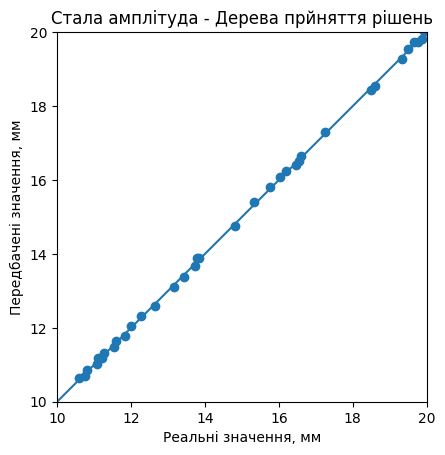

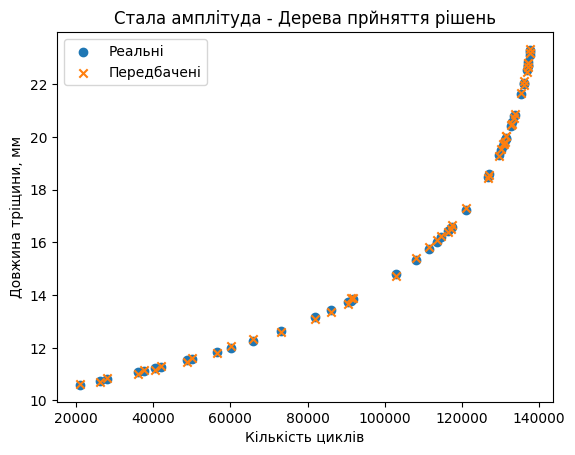

In [311]:
# Predict crack length vs. the number of cycles for CA using Decision Tree

# Train the model
CA_decision_tree = DecisionTreeRegressor(random_state=42)

CA_decision_tree.fit(X_train, y_train)

# Predict and evaluate performance on test data
y_pred = CA_decision_tree.predict(X_test)
mse1 = mean_squared_error(y_test, y_pred) 
print(f'MSE: {mse1}')

a = plt.axes(aspect='equal')
plt.scatter(y_test, y_pred)
plt.xlabel('Реальні значення, мм')
plt.ylabel('Передбачені значення, мм')
lims = [10, 20]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.title('Стала амплітуда - Дерева прйняття рішень')
plt.show()

plt.scatter(np.array(X_test)[:,0], y_test, label='Реальні', marker='o')
plt.scatter(np.array(X_test)[:,0], y_pred, label='Передбачені', marker='x')
plt.ylabel('Довжина тріщини, мм')
plt.xlabel("Кількість циклів")
plt.title('Стала амплітуда - Дерева прйняття рішень')
plt.legend()
plt.show()

MSE: 1.1757275958510363


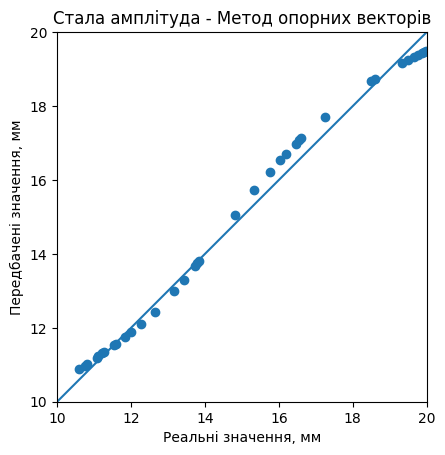

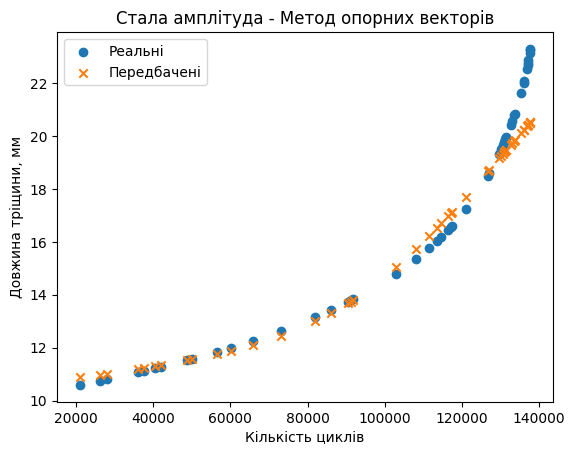

In [312]:
# Predict crack length vs. the number of cycles for CA using Support Vector Machine

# Train the model
CA_SVR = svm.SVR()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
random_state=42)


CA_SVR.fit(X_train, y_train)

# Predict and evaluate performance on test data
y_pred = CA_SVR.predict(X_test)
mse1 = mean_squared_error(y_test, y_pred)
print(f'MSE: {mse1}')

a = plt.axes(aspect='equal')
plt.scatter(y_test, y_pred)
plt.xlabel('Реальні значення, мм')
plt.ylabel('Передбачені значення, мм')
lims = [10, 20]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.title('Стала амплітуда - Метод опорних векторів')
plt.show()

plt.scatter(np.array(X_test)[:,0], y_test, label='Реальні', marker='o')
plt.scatter(np.array(X_test)[:,0], y_pred, label='Передбачені', marker='x')
plt.ylabel('Довжина тріщини, мм')
plt.xlabel("Кількість циклів")
plt.title('Стала амплітуда - Метод опорних векторів')
plt.legend()
plt.show()



MSE: 0.0031436104039289474


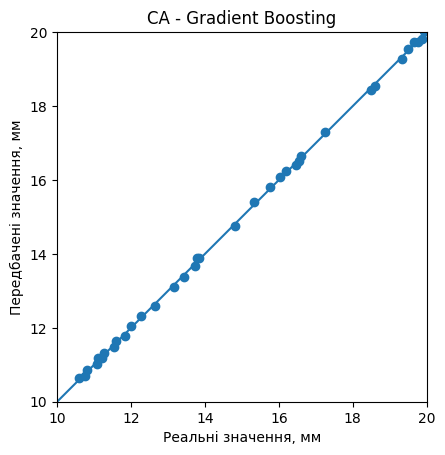

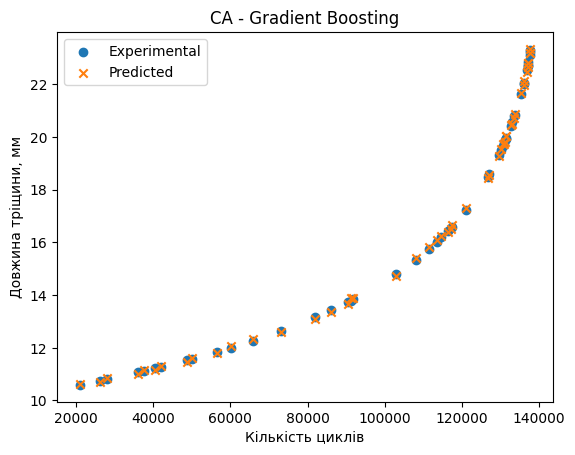

In [313]:
CA_gradient_boosting = GradientBoostingRegressor(n_estimators=10000)

CA_gradient_boosting.fit(X_train, y_train)

# Predict and evaluate performance on test data
y_pred = CA_gradient_boosting.predict(X_test)
mse1 = mean_squared_error(y_test, y_pred)
print(f'MSE: {mse1}')

a = plt.axes(aspect='equal')
plt.scatter(y_test, y_pred)
plt.xlabel('Реальні значення, мм')
plt.ylabel('Передбачені значення, мм')
lims = [10, 20]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.title('CA - Gradient Boosting')
plt.show()

plt.scatter(np.array(X_test)[:,0], y_test, label='Experimental', marker='o')
plt.scatter(np.array(X_test)[:,0], y_pred, label='Predicted', marker='x')
plt.ylabel('Довжина тріщини, мм')
plt.xlabel("Кількість циклів")
plt.title('CA - Gradient Boosting')
plt.legend()
plt.show()


In [314]:
CA_models = {"Random Forest": CA_random_forest, "Decision Tree": CA_decision_tree,
"SVR": CA_SVR, "Gradient Boosting": CA_gradient_boosting}

print("CA")
for name, model in CA_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate performance metrics
    errors = abs(y_pred - y_test)
    mae = round(np.mean(errors), 2)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    mse = mean_squared_error(y_test, y_pred)

    # Calculate accuracy
    accuracy = 100 - mape

    print(f'{name} MSE: {mse}, MAE {mae}, MAPE {mape}, Accuracy: {accuracy}%')

CA
Random Forest MSE: 0.0013989550480600693, MAE 0.03, MAPE 0.20847178536900662, Accuracy: 99.79152821463099%
Decision Tree MSE: 0.0031436102000000116, MAE 0.05, MAPE 0.34768654792119247, Accuracy: 99.6523134520788%
SVR MSE: 1.1757275958510363, MAE 0.7, MAPE 3.4931001326732956, Accuracy: 96.50689986732671%
Gradient Boosting MSE: 0.0031436104039289474, MAE 0.05, MAPE 0.34768655944874133, Accuracy: 99.65231344055125%
